In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, RobustScaler, MinMaxScaler, StandardScaler
from scipy.special import boxcox, boxcox1p
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

In [2]:
alz_df = pd.read_csv("C:/Users/JT/Desktop/CU Boulder/mri-and-alzheimers/oasis_cross-sectional.csv")
alz_df.info()
alz_df = alz_df.iloc[:,:-1]
alz_df.dropna(axis='rows',inplace=True)
alz_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 12 columns):
ID       436 non-null object
M/F      436 non-null object
Hand     436 non-null object
Age      436 non-null int64
Educ     235 non-null float64
SES      216 non-null float64
MMSE     235 non-null float64
CDR      235 non-null float64
eTIV     436 non-null int64
nWBV     436 non-null float64
ASF      436 non-null float64
Delay    20 non-null float64
dtypes: float64(7), int64(2), object(3)
memory usage: 41.0+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 216 entries, 0 to 415
Data columns (total 11 columns):
ID      216 non-null object
M/F     216 non-null object
Hand    216 non-null object
Age     216 non-null int64
Educ    216 non-null float64
SES     216 non-null float64
MMSE    216 non-null float64
CDR     216 non-null float64
eTIV    216 non-null int64
nWBV    216 non-null float64
ASF     216 non-null float64
dtypes: float64(6), int64(2), object(3)
memory usage: 20.2+ KB


In [3]:
alz_df.drop(columns=['ID','Hand', 'ASF'], inplace=True)
alz_df['M/F'] = alz_df['M/F'].astype('category')
alz_df['Educ'] = alz_df['Educ'].astype('category')
alz_df['SES'] = alz_df['SES'].astype('category')
alz_df['CDR'] = alz_df['CDR'].astype('category')

Above, I dropped ID and hand as ID is just the unique identifier and 'Hand' compries only of 1 unique value. Additionally, I dropped ASF as it is highly correlated with eTIV. This makes sense since ASF is the scaling factor used to normalize eTIV.

In [4]:
X = pd.DataFrame(alz_df[['M/F','Age', 'Educ','SES', 'MMSE','eTIV','nWBV']])
y= pd.DataFrame(alz_df[['CDR']])
X.drop('MMSE', inplace=True, axis='columns')
 

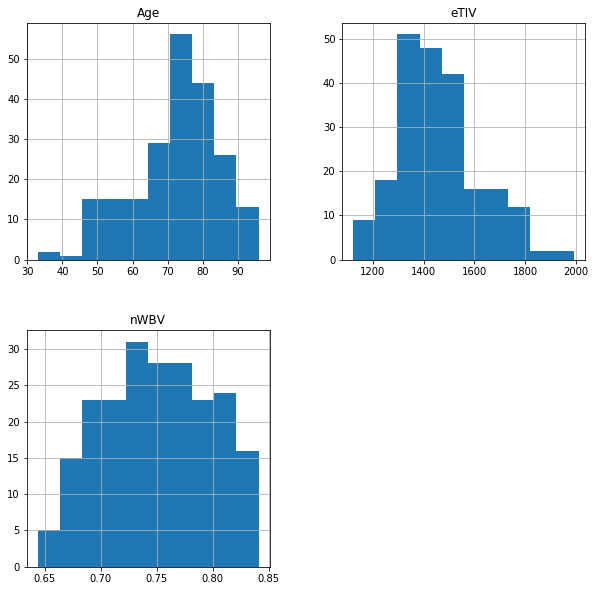

In [5]:
X.hist(figsize=(10,10))
plt.show()

In [6]:
encoder = LabelEncoder()
X = pd.get_dummies(X)
y = encoder.fit_transform(y)
X.head()

C:\Users\JT\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Age,eTIV,nWBV,M/F_F,M/F_M,Educ_1.0,Educ_2.0,Educ_3.0,Educ_4.0,Educ_5.0,SES_1.0,SES_2.0,SES_3.0,SES_4.0,SES_5.0
0,74,1344,0.743,1,0,0,1,0,0,0,0,0,1,0,0
1,55,1147,0.810,1,0,0,0,0,1,0,1,0,0,0,0
2,73,1454,0.708,1,0,0,0,0,1,0,0,0,1,0,0
8,74,1636,0.689,0,1,0,0,0,0,1,0,1,0,0,0
9,52,1321,0.827,1,0,0,0,1,0,0,0,1,0,0,0


In [7]:
#normalizing data
for i in range(X.shape[1]):
    boxcox1p(X.iloc[:,i], ss.boxcox_normmax(X.iloc[:,i]+1))



scaler = RobustScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

C:\Users\JT\Anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\JT\Anaconda3\lib\site-packages\scipy\stats\stats.py:3538: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


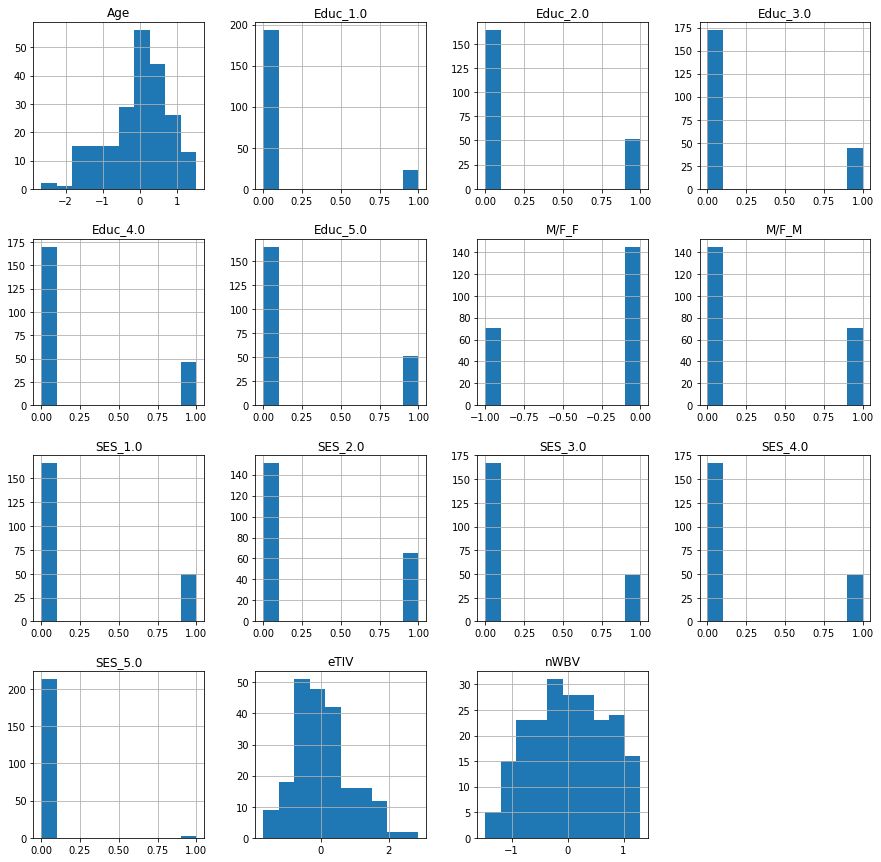

In [8]:
X.hist(figsize=(15,15))
plt.show()

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 17)
logreg = LogisticRegression(solver='saga', penalty='l1', max_iter=2000, multi_class='multinomial')
#logreg = LogisticRegression(solver='lbfgs', penalty='l2', max_iter=2000, multi_class='multinomial')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('Accuracy', accuracy_score(y_pred,y_test))
print(X.columns)
print(logreg.coef_)


Accuracy 0.7727272727272727
Index(['Age', 'eTIV', 'nWBV', 'M/F_F', 'M/F_M', 'Educ_1.0', 'Educ_2.0',
       'Educ_3.0', 'Educ_4.0', 'Educ_5.0', 'SES_1.0', 'SES_2.0', 'SES_3.0',
       'SES_4.0', 'SES_5.0'],
      dtype='object')
[[ 0.         -0.06365848  1.30222659  0.          0.         -0.02732302
   0.          0.          0.          0.63412323  0.          0.0627405
   0.         -0.14108387  0.        ]
 [ 0.12870285  0.10545747  0.11301018 -0.16548219  0.16548219  0.
  -0.04167921  0.01731009  0.          0.         -0.10405395  0.
   0.45286606  0.          0.        ]
 [ 0.          0.         -0.8063228   0.23198894 -0.23198894  0.
   0.49115162  0.          0.          0.          0.          0.
  -0.28290329  0.          0.        ]
 [ 0.          0.         -0.38387784  0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]


In [26]:
coefs_df = pd.DataFrame(logreg.coef_, columns=X.columns)
coefs_df.index = ['CDR=0', 'CDR=0.5', 'CDR=1', 'CDR=2']
coefs_df.to_csv(r'C:\Users\JT\Desktop\CU Boulder\CSCI 5622\Project\Coefs_table.csv')

In [57]:
alz_df[alz_df['CDR']==0.5]['SES'].value_counts()

3.0    16
4.0    15
2.0    14
1.0    11
5.0     1
Name: SES, dtype: int64